In [1]:
%load_ext autoreload
from mps.state import *

# TIME EVOLUTION

In [2]:
# file: mps/evolution.py

import numpy as np
import scipy.linalg
from mps.state import _truncate_vector

Some of the commonly used operators:

In [3]:
# file: mps/evolution.py

σz = np.diag([1.0,-1.0])
i2 = np.identity(2)
σx = np.array([[0, 1], [1, 0]])
σy = -1j * σz @ σx

def creation_op(d):
    # Returns d dimensional cration operator
    return np.diag(np.sqrt(np.arange(1,d)),-1).astype(complex)

def annihilation_op(d):
    # Returns d dimensional cration operator
    return np.diag(np.sqrt(np.arange(1,d)),1).astype(complex)



## Nearest Neighbor Hamiltonians

Below is the interface we use for nearest neighbor interaction Hamiltonians. It is initially empty.

In [4]:
# file: mps/evolution.py

class NNHamiltonian(object):
    
    def __init__(self, size):
        #
        # Create a nearest-neighbor interaction Hamiltonian
        # of a given size, initially empty.
        #
        self.size = size

    def local_term(self, ndx, t=0.0):
        #
        # Return the local term acting on the ndx site.
        #
        return 0
    
    def interaction_term(self, ndx, t=0.0):
        #
        # Return the interaction between sites (ndx,ndx+1)
        #
        return 0

A particular case would be a translationally invariant, constant Hamiltonian
$$H = \sum_i \left[O + \sum_n L^{(n)} \otimes R^{(n)}\right]_\text{site i}$$
which has the same local term $O$ on all sites, and the same interaction given by the product of $L^{(n)}$ left and $R^{(n)}$ right operators.

In [5]:
# file: mps/evolution.py

class TINNHamiltonian(NNHamiltonian):
    
    def __init__(self, local_term, intL, intR):
        #
        # Create a nearest-neighbor interaction Hamiltonian with fixed
        # local terms and interactions.
        #
        #  - local_term: operator acting on every site
        #  - int_left: list of L (applied to site ndx) operators
        #  - int_right: list of R (applied to site ndx + 1) operators
        #  - interaction: kronecker product of corresponding L and R pairs
        #
        self.local = local_term
        self.int_left = intL
        self.int_right = intR
        self.interaction = np.array([np.kron(L,R) for L,R in zip(intL, intR)]).sum(axis = 0)

    def local_term(self, ndx, t=0.0):
        #
        # Return the local term acting on the ndx site.
        #
        return self.local
    
    def interaction_term(self, ndx, t=0.0):
        #
        # Return the interaction between sites (ndx,ndx+1)
        #
        return self.interaction

In increasing level of complexity, we can have different local terms and different interactions on every site
$$H = \sum_i \left[O_i + \sum_n L^{(n)}_i \otimes R^{(n)}_i\right]_\text{site i}$$

In [6]:
# file: mps/evolution.py

class ConstantNNHamiltonian(NNHamiltonian):
    
    def __init__(self, size):
        #
        # Create a nearest-neighbor interaction Hamiltonian with fixed
        # local terms and interactions.
        #
        #  - local_term: operators acting on each site (can be different for each site)
        #  - int_left, int_right: list of L and R operators (can be different for each site)
        #
        self.local_terms = [0] * size
        self.int_left = [[]] * (size-1)
        self.int_right = [[]] * (size-1)
        self.interactions = [0] * (size-1)

    def set_local_term(self, ndx, operator):
        #
        # Set the local term acting on the given site
        #
        self.local_terms[ndx] = operator

    def add_interaction_term(self, ndx, L, R):
        #
        # Add an interaction term $L \otimes R$ acting on site 'ndx'
        #
        # Add to int_left, int_right
        #
        # Update the self.interactions[ndx] term
        self.int_left[ndx].append(L)
        self.int_right[ndx].append(R)
        self.interactions[ndx] += np.kron(L,R)

    def local_term(self, ndx, t=0.0):
        #
        # Return the local term acting on the ndx site.
        #
        return self.local_terms[ndx]
    
    def interaction_term(self, ndx, t=0.0):
        #
        # Return the interaction between sites (ndx,ndx+1)
        #
        return self.interactions[ndx]

## Suzuki-Trotter Decomposition

In Suzuki-Trotter decomposition, the Hamiltonians of the nearest neighbor couplings can be decomposed into two non-commuting parts, $H_{\text{odd}} $ and $ H_{\text{even}} $, so that all additive 2-site operators in each part commute with each other.

Let us consider a simple example of tight binding model with on-site potential and decompose the Hamiltonian into 2-site terms, so that $H=\sum_i h_{i,i+1}$. 
\begin{equation}
h_{i,i+1} = \left(\frac{\omega}{2}  a_i^\dagger a_i \right) + \left(\frac{\omega}{2}  a_{i+1}^\dagger a_{i+1} \right) - \left( t a_{i}^\dagger a_{i+1} + \text{h.c.} \right).
\end{equation}
Since $[h_{i,i+1},h_{i+2,i+3}] = 0$, we can group these terms for even and odd $i$, so that $H = H_{\text{odd}} + H_{\text{even}} $. 

Note that the local term $ a_i^\dagger a_i$ appears only in one the groups for $i=1$ and $i=N$. Therefore we need to add two on-site terms $h_1 = \left(\frac{\omega}{2}  a_1^\dagger a_1 \right) $ and $h_N = \left(\frac{\omega}{2}  a_N^\dagger a_N \right) $, separately. So that $H_{\text{even}} \rightarrow H_{\text{evem}} + h_1$, and $h_N$ is included similarly depending on whether $N$ is even or odd.

And the evolution operator becomes
$$e^{-i \hat{H} \Delta t} = e^{-i \hat{H}_{\text{odd}} \Delta t}  e^{-i \hat{H}_{\text{even}} \Delta t} + O(\Delta t^2).$$

The class Trotter_unitaries creates a list of Trotter unitarities depending on evenodd value. 

If evenodd = 0:
$$ U_{\text{odds}} = [U_{1,2}, U_{3,4}, \dots ], $$
and if evenodd = 1:
$$ U_{\text{evens}} = [U_1, U_{2,3}, U_{4,5}, \dots ], $$
where $U_i = e^{-i h_{i} \Delta t}$ and $U_{i,i+1} = e^{-i h_{i,i+1} \Delta t}$. 

Note that the last element of  $U_{\text{odds/evens}}$ is $U_N$ if $N$ is even/odd, and $U_{N-1,N}$ otherwise.

In [7]:
# file: mps/evolution.py

class Trotter_unitaries(object):
    """"Create Trotter unitarities from a nearest-neighbor interaction Hamiltonian.
        
    Attributes:
    H = NNHamiltonian
    δt = Time step
    evenodd = 0, 1 depending on Trotter step
    """

    def __init__(self, H, δt):
        self.H = H
        self.δt = δt
        self.tensors = []
        
    def local_unitary(self, start):
        """Creates one-site exponentials from local H terms,
        they are applied to first and last sites depending on evenodd value"""
        Hloc = self.H.local_term(start)
        U = scipy.linalg.expm(-1j * self.δt * 0.5 * Hloc)
        return U
        
    def twosite_unitary(self, start):
        """Creates twp-site exponentials from interaction H terms"""
        Hloc1 = self.H.local_term(start)
        Hloc2 = self.H.local_term(start+1)
        H12 = self.H.interaction_term(start) + \
              0.5 * (np.kron(Hloc1, np.eye(Hloc2.shape[0])) + \
                     np.kron(np.eye(Hloc1.shape[0]), Hloc2))
        U = scipy.linalg.expm(-1j * self.δt * H12)
        U = U.reshape(Hloc1.shape[0],Hloc2.shape[0],Hloc1.shape[0],Hloc2.shape[0])
        return U
    
    

    

We apply each $U_{i,i+1} = e^{-i h_{i,i+1} \Delta t}$ to two neighbouring tensors, $A_i$ and $A_{i+1}$ simultaneously as shown below.

<img src="fig_pdf/apply_mpo_to2site.svg" style="max-width: 90%; width: 35em">

The resulting tensor $B$ is a two-site tensor. We split this tensor into two one-site tensors using left_orth_2site and right_orth_2site functions, which are defined in [this notebook](File%201c%20-%20Canonical%20form.ipynb). 

In [8]:
# file: mps/evolution.py

def apply_1siteTrotter(U, ψ, start):
    return np.einsum("ijk,mj -> imk ", ψ[start], U)

def apply_2siteTrotter(U, ψ, start):
    return np.einsum('ijk,klm,prjl -> iprm', ψ[start],
                     ψ[start+1], U)


In [9]:
# file: mps/evolution.py

def TEBD_sweep(H, ψ, δt, evenodd, tol=0):
    #
    # Apply a TEBD sweep by evolving with the pairwise Trotter Hamiltonian
    # starting from left/rightmost site and moving on the 'direction' (>0 right,
    # <0 left) by pairs of sites.
    #
    # - H: NNHamiltonian
    # - ψ: Initial state in CanonicalMPS form (modified destructively)
    # - δt: Time step
    # - evenodd: 0, 1 depending on Trotter step
    # - direction: where to move
    #
    Trotter = Trotter_unitaries(H, δt)
    def update_local_site(start, dr):
        # Apply local exponential and move
        A = apply_1siteTrotter(Trotter.local_unitary(start) , ψ, start)
        ψ.update_canonical(A, dr, tolerance=tol)
        
    def update_two_site(start, dr):
        # Apply combined local and interaction exponential and move
        AA = apply_2siteTrotter(Trotter.twosite_unitary(start) , ψ, start)
        ψ.update_canonical_2site(AA, dr, tolerance=tol)


    if ψ.center == 0:
        # Move rightwards
        dr = +1
    else:
        # Move leftwards
        dr = -1
    
    #
    # Loop over ψ, updating pairs of sites acting with the unitary operator
    # made of the interaction and 0.5 times the local terms
    #
    if dr < 0:
        j = ψ.size - 1
        if j%2 == evenodd:
            update_local_site(j, dr)
            j -= 1
        while j > 0:
            update_two_site(j - 1, dr)
            j -= 2
        if j == 0:
            update_local_site(j, dr)
    else:
        j = 0
        if j != evenodd:
            update_local_site(j, dr)
            j += 1
        while j < ψ.size - 1:
            update_two_site(j, dr)
            j += 2
        if j == ψ.size - 1:
            update_local_site(j, dr)            
            
    return ψ



## Error in Suzuki-Trotter decomposition

In the first order Suzuki-Trotter decomposition, evolution operator becomes
\begin{equation}
e^{-i \hat{H} \Delta t} = e^{-i \hat{H}_{\text{odd}} \Delta t}  e^{-i \hat{H}_{\text{even}} \Delta t} + O(\Delta t^2).
\label{eq:sterror}
\end{equation}
Note that after $T/\Delta t$ time steps, the accumulated error is in the order of $\Delta t$.
Higher order Suzuki-Trotter decompositions can be used to reduce error.




# Tests

In [19]:
# file: mps/test/test_TEBD.py
import unittest
import mps.state
from mps.evolution import *
from mps.test.tools import *



class TestTEBD_sweep(unittest.TestCase):
    
    def test_orthonormalization(self):
        #
        # We verify that our two-site orthonormalization procedure, 
        # does not change the state
        #
        δt = 0.1
        tol = 0
        H = TINNHamiltonian(0*σx, σx, σx)
        Trotter = Trotter_unitaries(H, δt)

        def left_ok(Ψ):
            for start in range(Ψ.size-1):            
                AA = apply_2siteTrotter(Trotter.twosite_unitary(start) , 
                                                      Ψ, start)
                A, AC = mps.state.left_orth_2site(AA,tol)
                AA_orth = np.einsum("ijk,klm -> ijlm", A, AC)
                self.assertTrue(similar(AA,AA_orth))
            
        test_over_random_mps(left_ok)
        
        def right_ok(Ψ):
            for start in range(Ψ.size-1):            
                AA = apply_2siteTrotter(Trotter.twosite_unitary(start) , 
                                                      Ψ, start)
                A, AC = mps.state.right_orth_2site(AA,tol)
                AA_orth = np.einsum("ijk,klm -> ijlm", AC, A)
                self.assertTrue(similar(AA,AA_orth))
            
        test_over_random_mps(right_ok)
    

        
       
        
    




In [20]:
%autoreload
suite1 = unittest.TestLoader().loadTestsFromNames(['__main__.TestTEBD_sweep'])
unittest.TextTestRunner(verbosity=2).run(suite1);

test_orthonormalization (__main__.TestTEBD_sweep) ... ok

----------------------------------------------------------------------
Ran 1 test in 1.182s

OK


## Tight Binding Model

In [12]:
def TB_hamiltonian(N, d, sigma, ω, tt):
    t_list = [tt]*(N-1)
    potential = [ω]*N 

    int_left = [tt * annihilation_op(d) , tt * creation_op(d)]
    int_right = [creation_op(d), annihilation_op(d)]

    hmps = ConstantNNHamiltonian(N)
    for i in range(N-1):
        hmps.set_local_term(i, potential[i] * creation_op(d)@annihilation_op(d))
        [hmps.add_interaction_term(i, int_left[j], int_right[j]) for j in range(len(int_left))]

    hmps.set_local_term(N-1, potential[-1] * creation_op(d)@annihilation_op(d))
    
    return hmps

## Test for Tight Binding Model

In [13]:
import mps.state
import scipy.sparse as sp
import numbers


In [14]:
d=2
# number of sites
N=20
# on-site energy / cavity freq.
ω = np.pi
# hopping parameter t
tt = ω / 10

# time step
Nit = 10
dt = 1e-2
Tf=dt*Nit

sigma=1

x0 = N//2
w0 = N//5
k0 = np.pi/2
γ=0.5
xx=np.arange(N)

hmps = TB_hamiltonian(N, d, sigma, ω, tt)
trotter = Trotter_unitaries(hmps, dt)
state0 = gaussian(N, x0, w0, k0)

state_can = CanonicalMPS(state0, 0, tolerance=1e-8)
norms = []
for i in range(Nit):
    print(i)
    state_can = TEBD_sweep(hmps, state_can, dt, 0, tol=1e-8)
    state_can = TEBD_sweep(hmps, state_can, dt, 1, tol=1e-8)
    norms.append(state_can.norm2())




0
1
2
3
4
5
6
7
8
9


## Comparison with exact evolution

In [15]:
def prepare_gaussian(xx,x0,w0,k0):
    state0 = np.exp(-(xx-x0)**2 / w0**2 + 1j * k0*xx)
    return state0 / np.linalg.norm(state0)

def evolve(x0, w0, k0, N, Tf, sigma, γ, ω, tt):
    xx=np.arange(N)
    state0=prepare_gaussian(xx,x0,w0,k0)

    HM = sp.diags([[tt]*N, ω, [tt]*N],
                  offsets=[-1,0,+1],
                  shape=(N,N),
                  dtype=np.complex128)
    if isinstance(Tf, numbers.Number):
        return sp.linalg.expm_multiply(-1j * Tf * HM, state0)
    else:
        return np.array([sp.linalg.expm_multiply(-1j * t * HM, state0)
                         for t in np.array(Tf)])
    
state_exact = evolve(x0, w0, k0, N, np.linspace(0, Tf, 21), sigma, γ, ω, tt)

In [16]:
Nit = 10
Ntotal = 6
error_list = []

dt = 1e-2
dt_list = dt * np.arange(1,30)
Nit_list = [int(Ntotal//dt) for dt in dt_list] 
overlap_list=[]

state0 = mps.state.gaussian(N, x0, w0, k0)

state_vec = prepare_gaussian(xx,x0,w0,k0)
for dt, Nit in zip(dt_list, Nit_list):
    print(dt)
    state_can = mps.state.CanonicalMPS(state0, 0, tolerance=1e-8)    
    state_exact = evolve(x0, w0, k0, N, dt*Nit, sigma, γ, ω, tt)
    for i in range(Nit):
        state_can = TEBD_sweep(hmps, state_can, dt, 0, tol=1e-8)
        state_can = TEBD_sweep(hmps, state_can, dt, 1, tol=1e-8)
    
    state_exact=state_exact/np.linalg.norm(state_exact)
    exact_mps = mps.state.wavepacket(state_exact)
    #state_can.__init__(normalize=True)
    error_list.append(np.mean(abs(mps.state.MPS(state_can[:]).all_expectation1\
                                 (creation_op(d)@annihilation_op(d))
                                 -np.abs(state_exact)**2)))
    overlap_list.append(1-abs(expectation.scprod(exact_mps,state_can)))



0.01
0.02
0.03
0.04
0.05
0.06
0.07
0.08
0.09
0.1
0.11
0.12
0.13
0.14
0.15
0.16
0.17
0.18
0.19
0.2
0.21
0.22
0.23
0.24
0.25
0.26
0.27
0.28
0.29


In [17]:
state_can.center

0

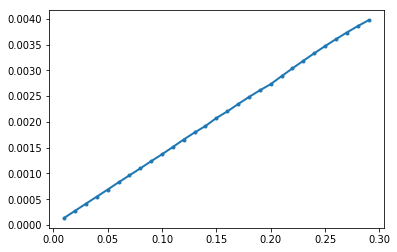

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(dt_list, error_list, ".-", linewidth=2)